In [1]:
import shap
import joblib

import datetime as dt
import sqlite3

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import (
    OneHotEncoder,
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from analytics.machine_learning.price_prediction_with_fundamentals import utils
import pandas as pd

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 3 months model

Target value counts
1    80412
0    77928
Name: next_three_months_pct_change_range, dtype: int64
Test set target value counts
0    4329
1    2343
Name: next_three_months_pct_change_range, dtype: int64
Overall Accuracy: 61.93%


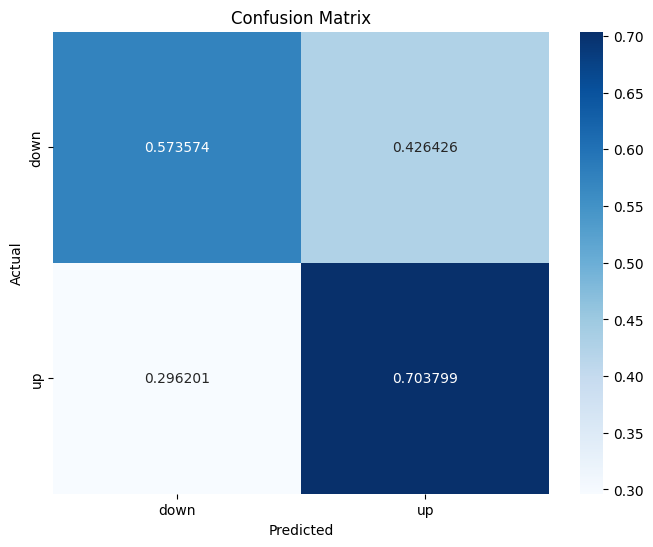

In [11]:
db_conn = sqlite3.connect('/Users/orestis/MyProjects/InvestorAPI/app/database/ibd.db')

query = '''
    SELECT * 
    FROM price_prediction_dataset_v2
    WHERE DATE(Date) <= date('now', '-3 months')
    ORDER BY DATE(Date)
'''

dataset = pd.read_sql(query, db_conn)
dataset.dropna(inplace=True)

# Create categorical target
bins = [-float('inf'), 0, float('inf')]
labels = ['down', 'up']
label_mapping = {0: 'down', 1: 'up'}

dataset['next_three_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_next_three_months'],
    bins=bins,
    labels=[0, 1],
    right=False
)

print("Target value counts")
print(dataset['next_three_months_pct_change_range'].value_counts())

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,8,1),
    cutoff_date_column_name='Date'
)

print("Test set target value counts")
print(test_set['next_three_months_pct_change_range'].value_counts())

cols_to_drop = ['symbol', 'Date', 'price_pct_change_next_six_months', 'price_pct_change_next_three_months', 'price_pct_change_next_month', 'next_three_months_pct_change_range']
target_col = 'next_three_months_pct_change_range'

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

rf_three_months_model = joblib.load('/Users/orestis/MyProjects/InvestorAPI/analytics/machine_learning/price_prediction_with_fundamentals/ml_models/rf_three_months_prediction_model.joblib') 

predicted_probabilities = rf_three_months_model.predict_proba(X_test)
y_pred = rf_three_months_model.predict(X_test)

X_test_high_probabilities = []
y_pred_high_probabilities = []
y_test_high_probabilities = []

for i in range(len(y_pred)):
    predicted_label = y_pred[i]
    predicted_probability = predicted_probabilities[i][predicted_label]
    if predicted_probability >= 0.75:
        X_test_high_probabilities.append(X_test.iloc[i])
        y_test_high_probabilities.append(y_test[i])
        y_pred_high_probabilities.append(y_pred[i])


accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2%}")

y_test_labels = [label_mapping[y] for y in y_test]
y_pred_labels = [label_mapping[y] for y in y_pred]
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Number of high probability predictions: 290
High prob predictions accuracy: 93.79%


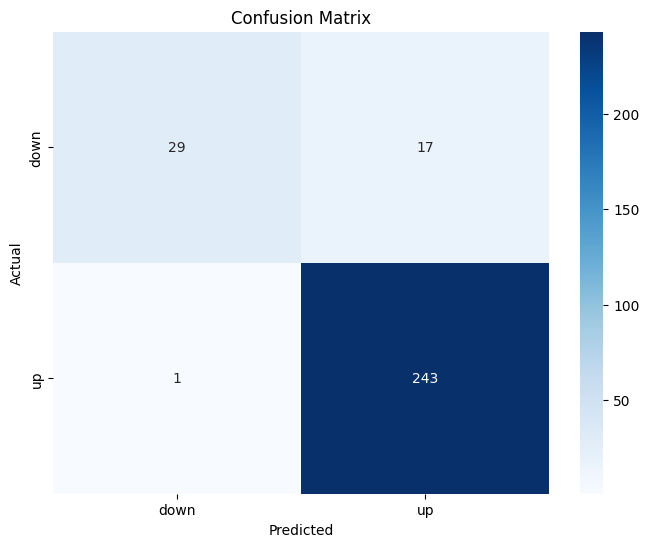

In [12]:
y_pred_high_prob, y_test_high_prob = utils.get_high_prob_predictions_with_ground_truth_labels(
    predicted_probabilities=predicted_probabilities,
    y_pred=y_pred,
    y_test=y_test,
    threshold=0.75
)

print("Number of high probability predictions:", len(y_pred_high_prob))
accuracy = accuracy_score(y_test_high_prob, y_pred_high_prob)
print(f"High prob predictions accuracy: {accuracy:.2%}")

y_test_labels = [label_mapping[y] for y in y_test_high_prob]
y_pred_labels = [label_mapping[y] for y in y_pred_high_prob]
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)#, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [3]:
len(y_pred_high_probabilities)

290

In [15]:
y_pred_high_probabilities[50:70]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

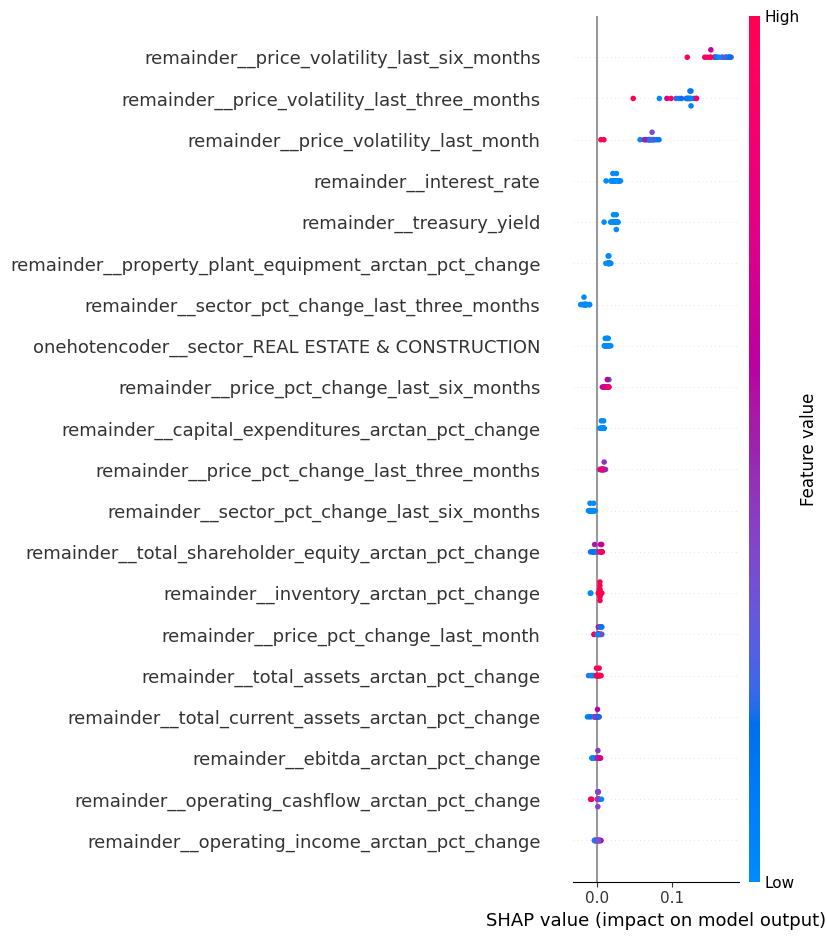

In [16]:
rf_classifier = rf_three_months_model.steps[1][1]
column_transformer = rf_three_months_model.steps[0][1]

explainer = shap.TreeExplainer(rf_classifier)
features = column_transformer.get_feature_names_out()

X_test_high_prob_subset = column_transformer.transform(pd.DataFrame(X_test_high_probabilities[50:70]))

shap_values = explainer.shap_values(X_test_high_prob_subset)
shap.summary_plot(shap_values[1],X_test_high_prob_subset, feature_names=features)

# 6 months model

Target value counts
1    76216
0    72127
Name: next_six_months_pct_change_range, dtype: int64
Test set target value counts
0    3478
1    3146
Name: next_six_months_pct_change_range, dtype: int64
Overall Accuracy: 69.16%


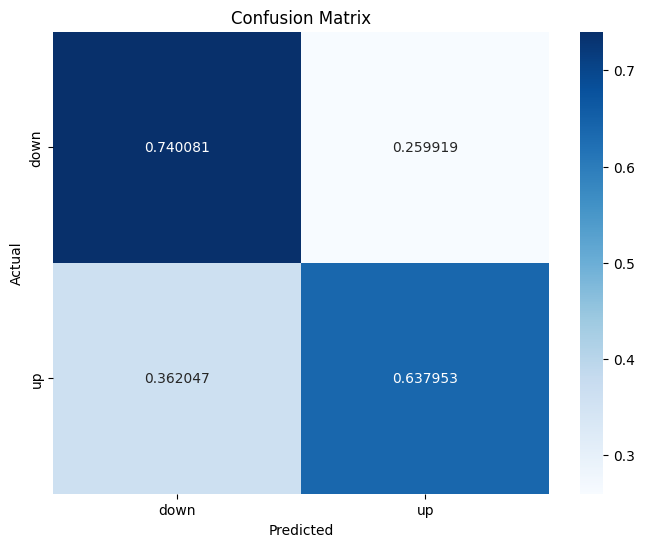

In [13]:
db_conn = sqlite3.connect('/Users/orestis/MyProjects/InvestorAPI/app/database/ibd.db')

query = '''
    SELECT * 
    FROM price_prediction_dataset_v2
    WHERE DATE(Date) <= date('now', '-6 months')
    ORDER BY DATE(Date)
'''

dataset = pd.read_sql(query, db_conn)
dataset.dropna(inplace=True)

# Create categorical target
bins = [-float('inf'), 0, float('inf')]
labels = ['down', 'up']
label_mapping = {0: 'down', 1: 'up'}

dataset['next_six_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_next_six_months'],
    bins=bins,
    labels=[0, 1],
    right=False
)

print("Target value counts")
print(dataset['next_six_months_pct_change_range'].value_counts())

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,5,1),
    cutoff_date_column_name='Date'
)

print("Test set target value counts")
print(test_set['next_six_months_pct_change_range'].value_counts())

cols_to_drop = ['symbol', 'Date', 'price_pct_change_next_six_months', 'price_pct_change_next_three_months', 'price_pct_change_next_month', 'next_six_months_pct_change_range']
target_col = 'next_six_months_pct_change_range'

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

rf_six_months_model = joblib.load('/Users/orestis/MyProjects/InvestorAPI/analytics/machine_learning/price_prediction_with_fundamentals/ml_models/rf_six_months_prediction_model.joblib') 

predicted_probabilities = rf_six_months_model.predict_proba(X_test)
y_pred = rf_six_months_model.predict(X_test)

X_test_high_probabilities = []
y_pred_high_probabilities = []
y_test_high_probabilities = []

for i in range(len(y_pred)):
    predicted_label = y_pred[i]
    predicted_probability = predicted_probabilities[i][predicted_label]
    if predicted_probability >= 0.75:
        X_test_high_probabilities.append(X_test.iloc[i])
        y_test_high_probabilities.append(y_test[i])
        y_pred_high_probabilities.append(y_pred[i])


accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2%}")

y_test_labels = [label_mapping[y] for y in y_test]
y_pred_labels = [label_mapping[y] for y in y_pred]
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Number of high probability predictions: 369
High prob predictions accuracy: 94.04%


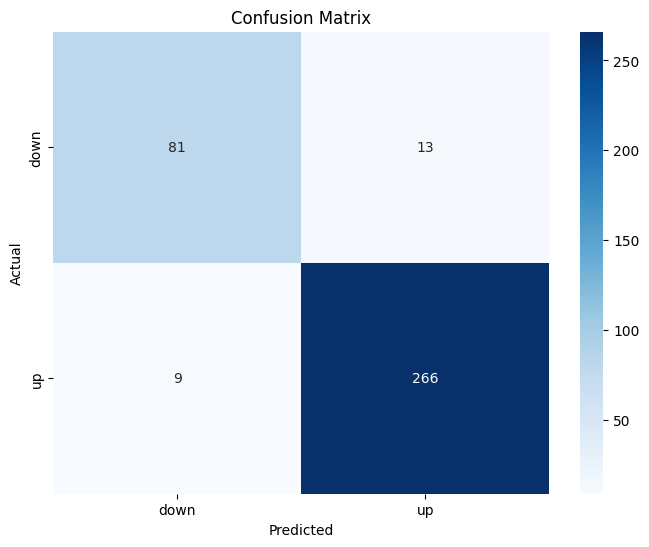

In [14]:
y_pred_high_prob, y_test_high_prob = utils.get_high_prob_predictions_with_ground_truth_labels(
    predicted_probabilities=predicted_probabilities,
    y_pred=y_pred,
    y_test=y_test,
    threshold=0.75
)

print("Number of high probability predictions:", len(y_pred_high_prob))
accuracy = accuracy_score(y_test_high_prob, y_pred_high_prob)
print(f"High prob predictions accuracy: {accuracy:.2%}")

y_test_labels = [label_mapping[y] for y in y_test_high_prob]
y_pred_labels = [label_mapping[y] for y in y_pred_high_prob]
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)#, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
y_pred_high_probabilities[100:120]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

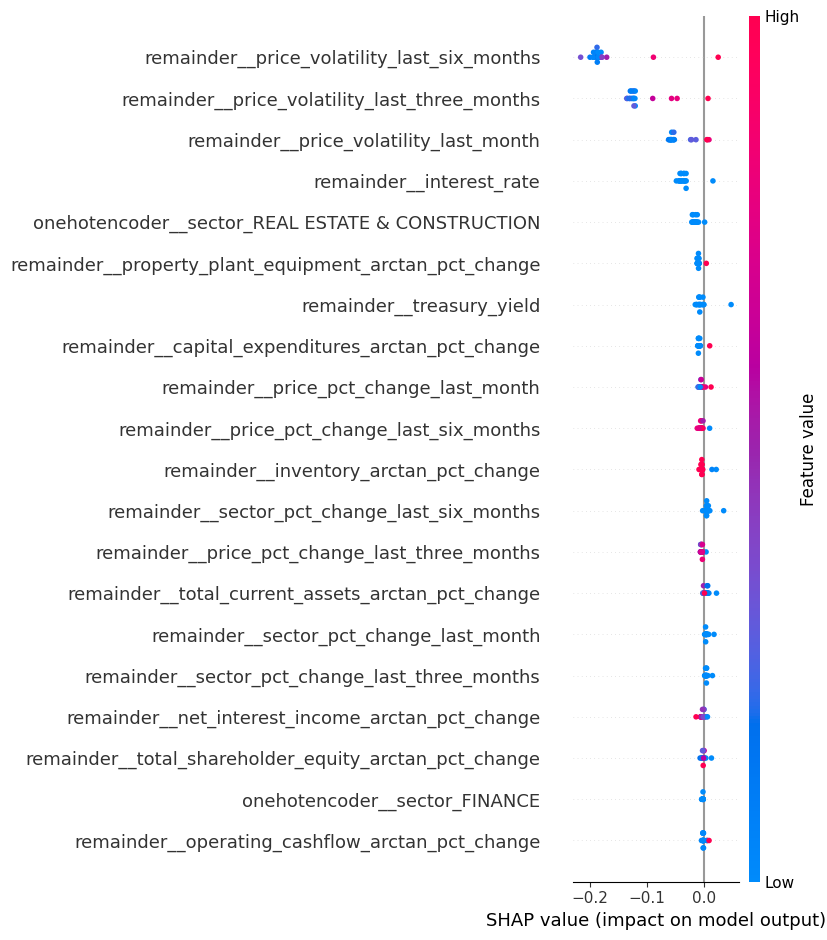

In [10]:
rf_classifier = rf_six_months_model.steps[1][1]
column_transformer = rf_six_months_model.steps[0][1]

explainer = shap.TreeExplainer(rf_classifier)
features = column_transformer.get_feature_names_out()

X_test_high_prob_subset = column_transformer.transform(pd.DataFrame(X_test_high_probabilities[100:120]))

shap_values = explainer.shap_values(X_test_high_prob_subset)
shap.summary_plot(shap_values[0],X_test_high_prob_subset, feature_names=features)